# 07: Decision Tree Classifier Feature Importance

### Imported Libraries

In [1]:
import sys
print('Python version: %s' % (sys.version))
from collections import Counter
print('\tCounter imported.')

# data management
print('\nData Management Libraries')
import pandas as pd
print('\tpandas version: %s' % (pd.__version__))
import numpy as np
print('\tnumpy version: %s' % (np.__version__))
import regex as re
print('\tregex version: %s' % (re.__version__))

# visualizing
print('\nVisualization Libraries')
from matplotlib import pyplot as plt
import matplotlib
print('\tmatplotlib version: %s' % (matplotlib.__version__))
import seaborn as sns
print('\tseaborn version: %s' % (sns.__version__))

# modeling
print('\nModeling Libraries')
import imblearn
print('\timblearn version: %s' % imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import sklearn
print('\tsklearn version: %s' % sklearn.__version__)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# feature importance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

Python version: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
	Counter imported.

Data Management Libraries
	pandas version: 1.2.3
	numpy version: 1.19.2
	regex version: 2.5.91

Visualization Libraries
	matplotlib version: 3.3.4
	seaborn version: 0.11.1

Modeling Libraries
	imblearn version: 0.8.0
	sklearn version: 0.24.1


### Update Library Settings

In [2]:
# set random state for reproducibility
random_state = 42

# default numpy settings
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80

# update settings
np.set_printoptions(edgeitems=15, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# update pandas settings
pd.options.display.max_columns = 12
pd.set_option('max_colwidth', 100) # sets the max number of columns before truncating with an ellipse
pd.options.display.max_rows = 500
pd.set_option('precision',6)

### Helper Functions

In [3]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy\t= %.2f" % (accuracy_score(y_actual, y_predicted)))
    print("Precision\t= %.2f" % (precision_score(y_actual, y_predicted)))
    print("Recall\t\t= %.2f" % (recall_score(y_actual, y_predicted)))
    print("F1 Score\t= %.2f" % (f1_score(y_actual, y_predicted)))
    pass
    
def plot_feature_correlation_heatmap(df,title,xsize,ysize):
    fig, ax = plt.subplots(1,1,figsize=(xsize,ysize))
    corr=df.corr()
    sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax)
    ax.set_title(title,fontsize=14)
    plt.show()
    
def plot_cmat_prc_roc(clf,X_test,y_test):
    fig, ax = plt.subplots(1,3,figsize=(16,4.5))
    plot_confusion_matrix(clf,X_test,y_test,ax=ax[0],cmap='Greys',colorbar=False) 
    ax[0].set_title('Confusion Matrix')
    plot_roc_curve(clf,X_test,y_test,ax=ax[1])
    ax[1].set_title('ROC Curve')
    plot_precision_recall_curve(clf,X_test,y_test,ax=ax[2])
    ax[2].set_title('Precision-Recall Curve')
    plt.show()

### Import Dataframe

In [4]:
df = pd.read_csv('../data/creditcard_03_notScaled.csv')

In [5]:
df.shape

(284807, 31)

In [6]:
df.head()

,Time_DayAware,Amount,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
0,0.0,149.62,-1.359807,-0.072781,2.536347,1.378155,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.0,2.69,1.191857,0.266151,0.166480,0.448154,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.0,378.66,-1.358354,-1.340163,1.773209,0.379780,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.0,123.50,-0.966272,-0.185226,1.792993,-0.863291,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,2.0,69.99,-1.158233,0.877737,1.548718,0.403034,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:
df.describe()

,Time_DayAware,Amount,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,52336.622709,88.349619,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,...,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,0.001727
std,21049.420490,250.120109,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,...,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,...,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,38153.500000,5.600000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,...,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,54039.000000,22.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,...,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,69587.000000,77.165000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,...,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,86398.000000,25691.160000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,...,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


### Separate Independent, Dependent Variables into DataFrames

In [8]:
X = df.drop('Class', axis=1)     # drop the output series from the dataset to isolate inputs (independent features)
y = df['Class']     # set y to the output series (dependent feature)

### Generate 'random noise' variables for permutation example

In [9]:
rng = np.random.RandomState(seed=random_state)
X['random_cat'] = rng.randint(3, size=X.shape[0]) # adds random variable that is high cardinality numerical variable
X['random_num'] = rng.randn(X.shape[0]) # adds random variable that is low cardinality categorical variable (3 possible categories)

### List variables by type for pipeline
Note: Used explicit list here (rather than programmatic solution) to help with user comprehension/review

In [10]:
%%time
# categorical variables
categorical_columns = ['random_cat']

# numerical variables
numerical_columns = ['random_num',
 'Time_DayAware',
 'Amount',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28']

Wall time: 0 ns


### Split into Train, Test
Note: It's important to **split test dataframe from training set prior to any resampling**. If data is resampled - then split into train/test - predictions will not mimic an *actual* environment. The purpose of a test dataframe is to simulate new inputs. By resampling the dataframe prior to split, the test dataframe no longer resembles a 'new input,' and as a result, ruins the predictive power of the model.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=random_state)     # setting training size of dataset to 70%

### Assemble variable lists for pipeline

In [12]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

clf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=random_state,n_jobs=-1))
])

##### Fit Random Forests

In [13]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['random_num',
                                                   'Time_DayAware', 'Amount',
                                                   'V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21

##### Predict Random Forests


[[85299     8]
 [   29   107]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.79      0.85       136

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443




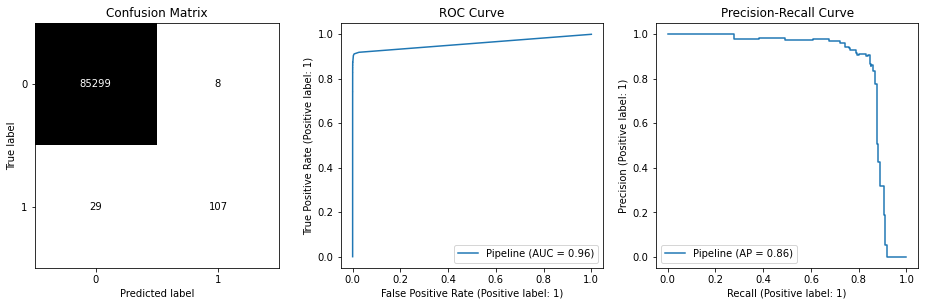

Accuracy	= 1.00
Precision	= 0.93
Recall		= 0.79
F1 Score	= 0.85



In [14]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)
print()

## Tree's Feature Importance from Mean Decrease in Impurity (MDI) with no resample RFC

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html    

This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the impurity-based feature importances of the forest, along with their inter-trees variability.    
As expected, the plot suggests that 3 features are informative, while the remaining are not.    
Warning Impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.

##### Horizontal bar

<ipython-input-15-24b686785fcc>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx]) # pass feature labels to y-axis labels


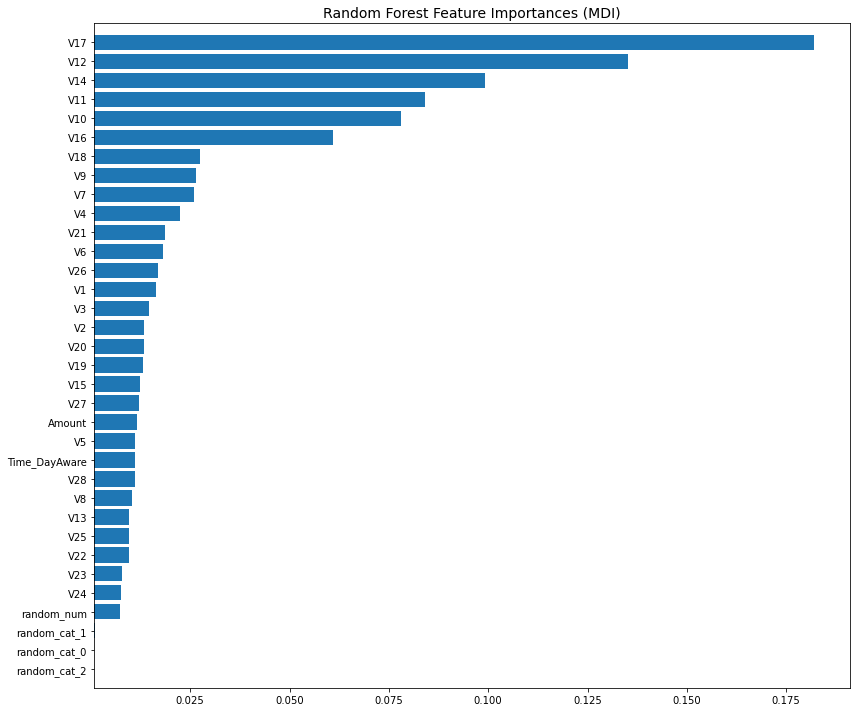

In [15]:
# generate chart for significance
ohe = (clf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    clf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(12,10))

tfi = tree_feature_importances[sorted_idx] # for ease of coding
space_range = (max(tfi) - min(tfi))*0.05

ax.barh(y_ticks, tfi) # set plot values

ax.set_xlim([min(tfi), max(tfi)+space_range]) # set x axis limits 0 to 5% over max range
ax.set_ylim([min(y_ticks)-1, max(y_ticks)+1]) # set y axis limits + 1 to top and bottom for spacing
ax.set_yticklabels(feature_names[sorted_idx]) # pass feature labels to y-axis labels
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)",fontsize=14)
fig.tight_layout()
plt.show()

##### Vertical bar

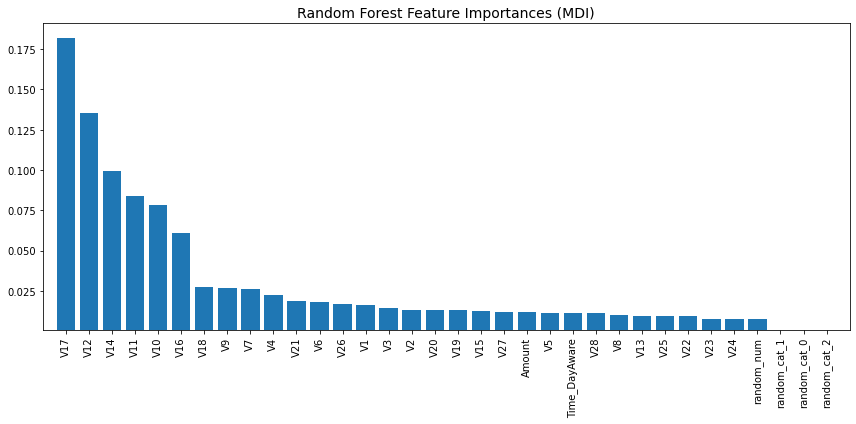

In [16]:
# generate chart for 
ohe = (clf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    clf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()[::-1]

x_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(12,6))

tfi = tree_feature_importances[sorted_idx] # for ease of coding
space_range = (max(tfi) - min(tfi))*0.05

ax.bar(x_ticks, tfi) # set plot values

ax.set_ylim([min(tfi), max(tfi)+space_range]) # set x axis limits 0 to 5% over max range
ax.set_xlim([min(y_ticks)-1, max(y_ticks)+1]) # set y axis limits + 1 to top and bottom for spacing

ax.set_xticks(x_ticks)
ax.set_xticklabels(feature_names[sorted_idx]) # pass feature labels to y-axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # rotate labels 90 degress

ax.set_title("Random Forest Feature Importances (MDI)",fontsize=14)
fig.tight_layout()
plt.show()

### Oversampling with Smote, Random Forest Classifier

In [17]:
sm = SMOTE(random_state=random_state)
smX_train,smy_train = sm.fit_resample(X_train,y_train)
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(smy_train))

Before fit: Counter({0: 199008, 1: 356})
After fit: Counter({0: 199008, 1: 199008})


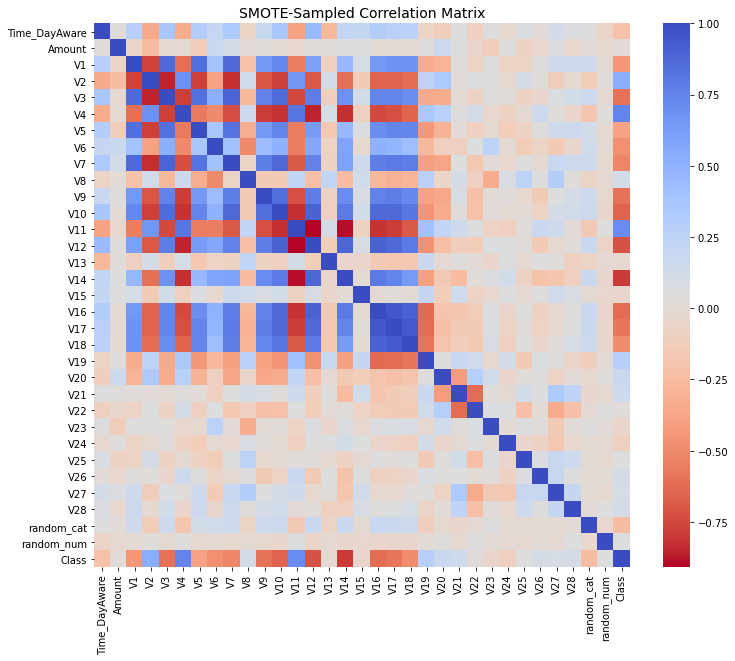

Wall time: 3.58 s


In [18]:
%%time
smote_df = smX_train.copy()
smote_df['Class'] = smy_train.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,10)

### Fit model to training dataframe (ie Train model)

In [19]:
%%time
clf.fit(smX_train, smy_train)

Wall time: 49.3 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['random_num',
                                                   'Time_DayAware', 'Amount',
                                                   'V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21

### Predict model


[[85282    25]
 [   17   119]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.88      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443




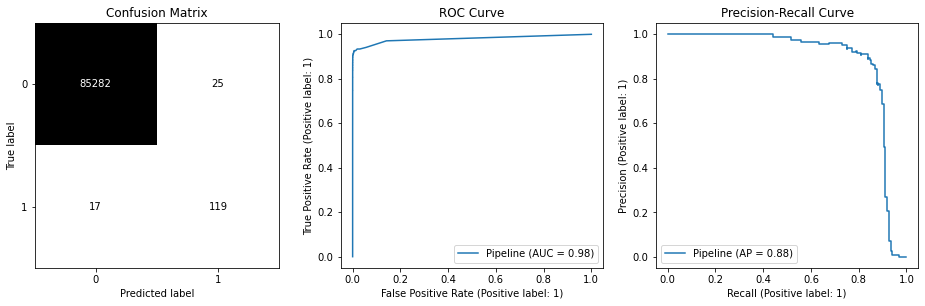

Accuracy	= 1.00
Precision	= 0.83
Recall		= 0.88
F1 Score	= 0.85



In [20]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)
print()

## MDI with smote

##### Horizontal bar

<ipython-input-21-ca450c0f4c60>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx]) # pass feature labels to y-axis labels


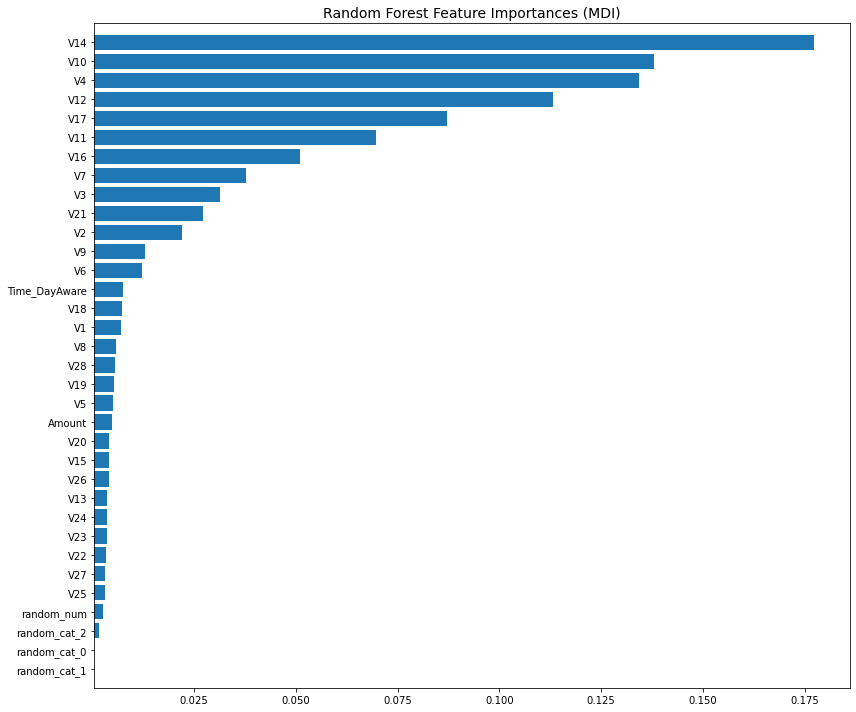

In [21]:
# generate chart for 
ohe = (clf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    clf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(12,10))

tfi = tree_feature_importances[sorted_idx] # for ease of coding
space_range = (max(tfi) - min(tfi))*0.05

ax.barh(y_ticks, tfi) # set plot values

ax.set_xlim([min(tfi), max(tfi)+space_range]) # set x axis limits 0 to 5% over max range
ax.set_ylim([min(y_ticks)-1, max(y_ticks)+1]) # set y axis limits + 1 to top and bottom for spacing
ax.set_yticklabels(feature_names[sorted_idx]) # pass feature labels to y-axis labels
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)",fontsize=14)
fig.tight_layout()
plt.show()

##### Vertical bar

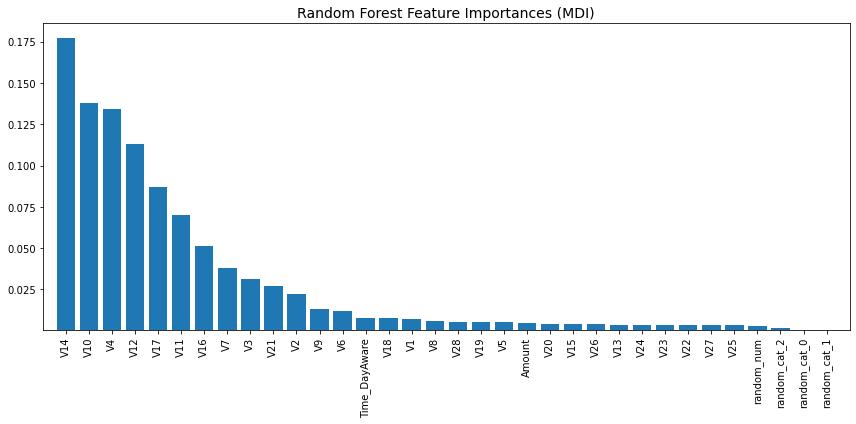

In [22]:
# generate chart for 
ohe = (clf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    clf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()[::-1]

x_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(12,6))

tfi = tree_feature_importances[sorted_idx] # for ease of coding
space_range = (max(tfi) - min(tfi))*0.05

ax.bar(x_ticks, tfi) # set plot values

ax.set_ylim([min(tfi), max(tfi)+space_range]) # set x axis limits 0 to 5% over max range
ax.set_xlim([min(y_ticks)-1, max(y_ticks)+1]) # set y axis limits + 1 to top and bottom for spacing

ax.set_xticks(x_ticks)
ax.set_xticklabels(feature_names[sorted_idx]) # pass feature labels to y-axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # rotate labels 90 degress

ax.set_title("Random Forest Feature Importances (MDI)",fontsize=14)
fig.tight_layout()
plt.show()

#### Get top half of MDI

In [23]:
tree_feature_importances = (
    clf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()[::-1]

tfl = feature_names[sorted_idx]
tfi = tree_feature_importances[sorted_idx]

for idx in range(len(sorted_idx)):
    print('%s: %f' % (tfl[idx],tfi[idx]))

V14: 0.177238
V10: 0.137905
V4: 0.134206
V12: 0.113112
V17: 0.087109
V11: 0.069804
V16: 0.050988
V7: 0.037809
V3: 0.031454
V21: 0.027151
V2: 0.022019
V9: 0.012891
V6: 0.012120
Time_DayAware: 0.007586
V18: 0.007348
V1: 0.007104
V8: 0.005921
V28: 0.005481
V19: 0.005263
V5: 0.005122
Amount: 0.004864
V20: 0.004100
V15: 0.004010
V26: 0.003990
V13: 0.003538
V24: 0.003523
V23: 0.003499
V22: 0.003247
V27: 0.003212
V25: 0.003204
random_num: 0.002715
random_cat_2: 0.001624
random_cat_0: 0.000435
random_cat_1: 0.000411


In [43]:
# Top Half
independent_var_count = int(len(df.columns)-1)
half_count = int(independent_var_count/2)
mdi_top = tfl[:half_count]
mdi_top

array(['V14', 'V10', 'V4', 'V12', 'V17', 'V11', 'V16', 'V7', 'V3', 'V21', 'V2', 'V9', 'V6', 'Time_DayAware', 'V18'], dtype=object)

## Permutation Importance on test set

In [25]:
%%time
test_pi = permutation_importance(clf, X_test, y_test,n_repeats=10,random_state=random_state,n_jobs=-1)

Wall time: 1min 3s


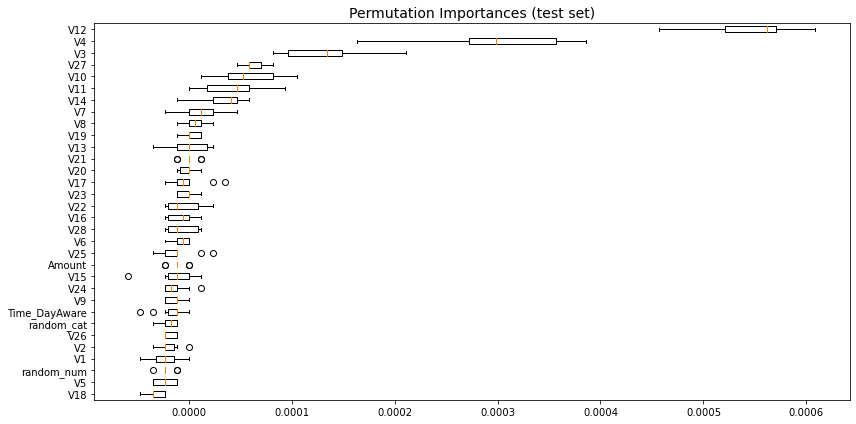

In [26]:
sorted_idx = test_pi.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(test_pi.importances[sorted_idx].T,vert=False,labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)",fontsize=14)
fig.tight_layout()
plt.show()

#### Get top half Permutation Importance

In [44]:
pi_top = X_test.columns[sorted_idx][:half_count:-1]
pi_top

Index(['V12', 'V4', 'V14', 'V3', 'V11', 'V10', 'V8', 'Time_DayAware', 'V17',
       'V1', 'V16', 'V20', 'Amount', 'V19', 'V28', 'V24'],
      dtype='object')

## Permutation Importance on training set

In [28]:
%%time
train_pi = permutation_importance(clf, smX_train, smy_train,n_repeats=10,random_state=random_state,n_jobs=-1)

Wall time: 4min 35s


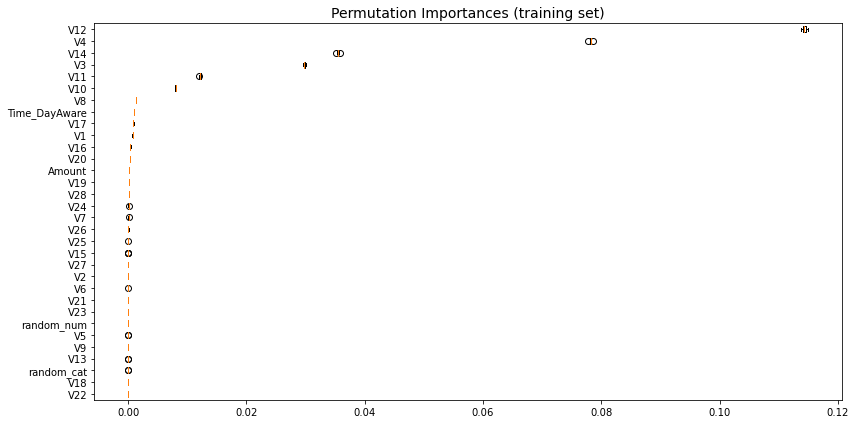

Wall time: 974 ms


In [29]:
%%time
sorted_idx = train_pi.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(train_pi.importances[sorted_idx].T,vert=False,labels=smX_train.columns[sorted_idx])
ax.set_title("Permutation Importances (training set)",fontsize=14)
fig.tight_layout()
plt.show()